Enter house base dimensions (width depth height): 100,100,100
✅ STL saved as: 3D_house_and_box.stl
✅ Topography saved as: Topography.png
✅ CSV saved as: distances_and_positions_of_elements.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

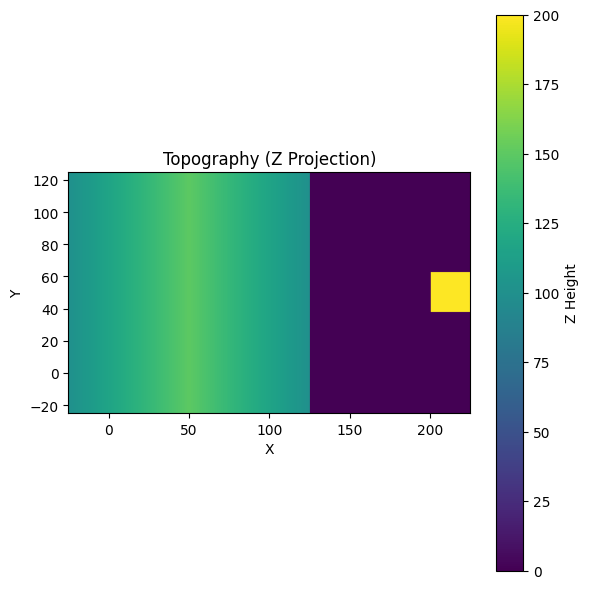

In [ ]:
# -------------------------------------------------------------
# ✅ Teramount Nano Print Engineer Home Task - 3D Modeling Script
# Description: Builds a 3D structure with a house and a box,
#              exports an STL file, creates a top-view projection,
#              and generates metadata in CSV format.
# -------------------------------------------------------------

# Install required packages in Google Colab (quiet mode)
!pip install -q cadquery trimesh rtree matplotlib pandas

# -------------------------------------------------------------
# 🔽 Import Libraries
# -------------------------------------------------------------
import cadquery as cq
from cadquery import exporters
import trimesh, numpy as np, pandas as pd, matplotlib.pyplot as plt
from google.colab import files

# -------------------------------------------------------------
# 📥 USER INPUT
# -------------------------------------------------------------
# Prompt user to input dimensions for the house base (width, depth, height)
w, d, h = map(float, input("Enter house base dimensions (width depth height): ").replace(',', ' ').split())

# Derived dimensions based on input
roof_h = 0.5 * h         # Height of roof
roof_d = 1.5 * d         # Depth of roof (longer than house base)
roof_oh = 0.25 * w       # Roof overhang on each side
roof_w = w + 2 * roof_oh # Total roof width including overhang

box_w = 0.25 * w         # Width of the box
box_d = 0.25 * d         # Depth of the box
box_h = 2 * h            # Height of the box

# Position of box relative to the house base
box_xmin = 2 * w
box_xmax = box_xmin + box_w
box_ymin = w / 2 - box_d / 2
box_ymax = w / 2 + box_d / 2

# -------------------------------------------------------------
# 🏗️ 3D MODEL CONSTRUCTION
# -------------------------------------------------------------

# 1. Create the house base (a simple box)
house_base = cq.Workplane("XY").box(w, d, h).translate((w / 2, d / 2, h / 2))

# 2. Create the roof as a triangular prism
roof = (
    cq.Workplane("XZ")
    .polyline([(-roof_w / 2, 0), (roof_w / 2, 0), (0, roof_h)])  # Triangle profile
    .close()
    .extrude(roof_d)  # Extrude along Y axis
    .translate((w / 2, d + d / 4, h))  # Move above house base
)

# 3. Create the external box
box = (
    cq.Workplane("XY")
    .box(box_w, box_d, box_h)
    .translate((2 * w + box_w / 2, 2 * box_d, box_h / 2))
)

# Combine all 3 elements into one scene
scene = cq.Compound.makeCompound([house_base.val(), roof.val(), box.val()])

# Export to STL file
stl_file = "3D_house_and_box.stl"
exporters.export(scene, stl_file)
print(f"✅ STL saved as: {stl_file}")

# -------------------------------------------------------------
# 🖼️ CREATE 2D Z-PROJECTION (Top View)
# -------------------------------------------------------------

# Load STL into trimesh for top-view projection
mesh = trimesh.load_mesh(stl_file)

# Create a 2D grid over the X-Y plane
grid_size = 400
xmin, ymin, _ = mesh.bounds[0]
xmax, ymax, zmax = mesh.bounds[1]
xi = np.linspace(xmin, xmax, grid_size)
yi = np.linspace(ymin, ymax, grid_size)
X, Y = np.meshgrid(xi, yi)
Z = np.zeros_like(X)

# Cast vertical rays downward from above the model
origins = np.column_stack((X.ravel(), Y.ravel(), np.full(X.size, zmax + 10)))
directions = np.tile([0, 0, -1], (X.size, 1))
locs, idx_rays, _ = mesh.ray.intersects_location(origins, directions)

# Fill Z values based on intersection heights
for loc, idx in zip(locs, idx_rays):
    iy, ix = divmod(idx, grid_size)
    Z[iy, ix] = max(Z[iy, ix], loc[2])

# Save top-view projection as PNG
plt.figure(figsize=(6, 6))
plt.imshow(Z, origin="lower", extent=(xmin, xmax, ymin, ymax), cmap="viridis")
plt.colorbar(label="Z Height")
plt.title("Topography (Z Projection)")
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.savefig("Topography.png", dpi=300)
print("✅ Topography saved as: Topography.png")

# -------------------------------------------------------------
# 📊 METADATA / DISTANCE MEASUREMENTS
# -------------------------------------------------------------

# Metadata for Element 1: House base and roof

house = dict(
    Element="Element 1",
    position_x=w / 2,
    position_y=d / 2,
    position_z=h / 2 + roof_h / 2,
    xmin=-roof_oh,
    xmax=w + roof_oh,
    ymin=-0.25 * d,
    ymax=d + 0.25 * d,
    zmin=0,
    zmax=h + roof_h,
    width=w + 2 * roof_oh,
    depth=1.5 * d,
    height=h + roof_h,
    corners=[
        (0, 0, 0), (0, 0, h), (0, d, 0), (0, d, h), (w, 0, 0), (w, 0, h), (w, d, 0), (w, d, h),
        (-roof_oh, -roof_oh, h), (-roof_oh, -roof_oh, h + roof_h),
        (-roof_oh, d + roof_oh, h), (-roof_oh, d + roof_oh, h + roof_h),
        (w + roof_oh, -roof_oh, h), (w + roof_oh, -roof_oh, h + roof_h),
        (w + roof_oh, d + roof_oh, h), (w + roof_oh, d + roof_oh, h + roof_h)
    ],
    **{"z range": "", "X-Distance(z)": ""}
)

box_meta = dict(
    Element="Element 2",
    position_x=box_xmin + box_w / 2,
    position_y=2 * 0.25 * d,  # box_d = 0.25*d
    position_z=2 * h / 2,     # box_h = 2*h
    xmin=box_xmin,
    xmax=box_xmin + box_w,
    ymin=(w / 2) - (0.25 * d) / 2,
    ymax=(w / 2) + (0.25 * d) / 2,
    zmin=0,
    zmax=2 * h,
    width=box_w,
    depth=0.25 * d,
    height=2 * h,
    corners=[
        (box_xmin, (w / 2) - (0.25 * d) / 2, 0), (box_xmin, (w / 2) - (0.25 * d) / 2, 2 * h),
        (box_xmin, (w / 2) + (0.25 * d) / 2, 0), (box_xmin, (w / 2) + (0.25 * d) / 2, 2 * h),
        (box_xmin + box_w, (w / 2) - (0.25 * d) / 2, 0), (box_xmin + box_w, (w / 2) - (0.25 * d) / 2, 2 * h),
        (box_xmin + box_w, (w / 2) + (0.25 * d) / 2, 0), (box_xmin + box_w, (w / 2) + (0.25 * d) / 2, 2 * h)
    ],
    **{"z range": "", "X-Distance(z)": ""}
)

distance_data = [
    {"Element": "—", "z range": f"0 < z < {w}", "X-Distance(z)": f"{w}"},
    {"Element": "—", "z range": f"{h} < z < {h + roof_h}", "X-Distance(z)": f"1.5*(z - {w}) + {box_xmin - (w + roof_oh)}"},
]

# Keys for metadata, exclude last two keys ("z range", "X-Distance(z)")
meta_keys = [k for k in house.keys() if k not in ["z range", "X-Distance(z)"]]

# Create metadata DataFrame with selected columns only
df_meta = pd.DataFrame([{k: house[k] for k in meta_keys},
                        {k: box_meta[k] for k in meta_keys}])

# Create distance DataFrame with only 'z range' and 'X-Distance(z)'
df_dist = pd.DataFrame([{k: d[k] for k in ["z range", "X-Distance(z)"]} for d in distance_data])

# Write to CSV with separation
csv_file = "distances_and_positions_of_elements.csv"
with open(csv_file, "w") as f:
    df_meta.to_csv(f, index=False)
    f.write("\n# Distance Data\n")
    df_dist.to_csv(f, index=False)

print(f"✅ CSV saved as: {csv_file}")

# -------------------------------------------------------------
# 📥 DOWNLOAD RESULTS
# -------------------------------------------------------------
for f in (stl_file, "Topography.png", csv_file):
    files.download(f)
